In [ ]:
# I'm going to analyse the dataset that netflix releases about the first semester of 2023
# To do that i'm going to also use two datasets from IMDB to have access at 
# the IMDB rating of all the contents in Netflix
# We will try to analyse if there is some relationship between the rating and the viewership
# We will make some visual presentations of the datas in this datasets and see some relationships 

In [139]:
#we start by importing all the libraries we will need
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [140]:
df = pd.read_excel('/Users/arnaud/Netflix project/what_we_watch_netflix.xlsx')
#upload the excel file with Netflix hours viewed

In [141]:
#so now we are going to start the cleaning and porcessing of the datas
df.head()
#we look at the table

,Unnamed: 0,Title,Available Globally?,Release Date,Hours Viewed
0,NaN,The Night Agent: Season 1,Yes,2023-03-23,812100000
1,NaN,Ginny & Georgia: Season 2,Yes,2023-01-05,665100000
2,NaN,The Glory: Season 1 // 더 글로리: 시즌 1,Yes,2022-12-30,622800000
3,NaN,Wednesday: Season 1,Yes,2022-11-23,507700000
4,NaN,Queen Charlotte: A Bridgerton Story,Yes,2023-05-04,503000000


In [142]:
# we delete the column "unnamed because it dosen't give any exploitables information
df = df.drop('Unnamed: 0', axis=1)
# we look a the number of entries
print(len(df))
#we look at the nulle values
print((df.isnull()).sum())
# we see a lot of nulle values in the release date column, we will keep this column for the moment


18214
Title                      0
Available Globally?        0
Release Date           13359
Hours Viewed               0
dtype: int64


In [143]:
#we llok a the duplicates in the title column
print(sum(df.duplicated(subset=['Title'])))
#we check the data types of each column
print(df.dtypes)


0
Title                          object
Available Globally?            object
Release Date           datetime64[ns]
Hours Viewed                    int64
dtype: object


In [144]:
#we change the name of the column "available globally"
df.rename(columns={'Available Globally?': 'Available Globally'}, inplace=True)
#we check if all the values on the column 'Available Globally' are 'Yes or 'No'
print(len(df[df['Available Globally'] == 'Yes']) + len(df[df['Available Globally'] == 'No']))
#to only keep the title in english because the format is 'name of show' // name of show in original language
df["Title"] = df["Title"].str.split('//', 1).str[0]
#We put all the titles in lower
df['Title'] = df['Title'].str.lower()
#Extract the number from the parenthesis and add it to the ' Year' column
df['Year'] = df['Title'].str.extract(r'\((\d+)\)')
# Remove the extracted number from the 'Title' column with season before for tv shows
df['Title'] = df['Title'].str.replace(r': season \d+', '')
#deleting the () with date at the end of the movies
df['Title'] = df['Title'].str.replace(r' \(\d+\)$', '')
# Convert 'Release Year' to numeric type integer and fill the titles that don't have this format with 0
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(0).astype(int)


18214


/var/folders/mc/jsq8hvk57wb40w3clh781l000000gn/T/ipykernel_70010/2985885671.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Title'] = df['Title'].str.replace(r': season \d+', '')
/var/folders/mc/jsq8hvk57wb40w3clh781l000000gn/T/ipykernel_70010/2985885671.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Title'] = df['Title'].str.replace(r' \(\d+\)$', '')


In [145]:
#Extract the year of the release date as an integer and fill the titles that don't have release date with 0
df['Year_1'] = df['Release Date'].dt.year.fillna(0).astype(int)
#we merge the two columns year to have only one left with the date from the parentesis and the date from release
#date column
df['year'] = df['Year'] + df ['Year_1']
#we aggregate the hours viewed of the seasons of a show, and keeping the oldest date because in the IMDB dataset 
#the tv shows have only one date, the date of the release of the first season
result_df = df.groupby('Title').agg({'Hours Viewed': 'sum', 'Available Globally': 'first','year':'min'}).reset_index()
#delete the # a the beginning of some title
result_df['Title'] = result_df['Title'].str.lstrip('#')
#deleting spaces before and after the titles
result_df['Title'] = result_df['Title'].str.strip()


In [148]:
print((result_df == 0).sum())
#we see that with the cleaning and the transformation, we were able to get 500 more date
#because witht the transformations, we have now a table with 15532 entries which makes more or less 5300 entries 

Title                     0
Hours Viewed              0
Available Globally        0
year                  10151
dtype: int64


In [167]:
#We import the Imdb title dataset
df_title = pd.read_csv('title.basics.tsv', sep='\t')
df_title.head()

/var/folders/mc/jsq8hvk57wb40w3clh781l000000gn/T/ipykernel_70010/3261192721.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_title = pd.read_csv('title.basics.tsv', sep='\t')


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [169]:
#we transform the tconst column to have an integer that starts at 1
df_title['tconst'] = df_title['tconst'].str.replace(r'^[^1-9]+', '', regex=True)
#we rename it Id
df_title.rename(columns={'tconst': 'Id'}, inplace=True)
#we transform the datatype on int
df_title['Id'].astype(int)

#now we are going to deal with the titletype column
#we are changing the name of the column
# we are dropping everything that is not movies or tv series
df_title.rename(columns={'titleType': 'Type'}, inplace=True)
df_title_filter = df_title[df_title['Type'].isin(['movie','tvSeries'])]

# we are dropping the endYear column 
df_title_filter = df_title_filter.drop('endYear', axis=1)
# we are dropping original title column 
df_title_filter = df_title_filter.drop('originalTitle', axis=1)

# we rename the column primary title
df_title_filter.rename(columns={'primaryTitle': 'Title'},inplace=True)

#we don't know yet if we will need the is Adult column yet but we will anyway transform it
df_title_filter.rename(columns={'isAdult': 'Adult'}, inplace=True)
#replace 0 and 1 by yes and no
df_title_filter['Adult'].replace(0, 'No', inplace=True)
df_title_filter['Adult'].replace(1, 'Yes', inplace=True)
#check the duplicate in title column
print(sum(df_title_filter.duplicated(subset=['Title'])))


133643


In [171]:
#so we see that we have duplicates in the Title column which can be normal as a movies can have the same name
#check for duplicate in the Id column
print(sum(df_title_filter.duplicated(subset=['Id'])))

0


In [172]:
#We check for the nan values and none in the columns
print((df_title_filter.isnull()).sum())
print((df_title_filter.isna()).sum())

Id                0
Type              0
Title             0
Adult             0
startYear         0
runtimeMinutes    0
genres            0
dtype: int64
Id                0
Type              0
Title             0
Adult             0
startYear         0
runtimeMinutes    0
genres            0
dtype: int64


In [175]:
#we replace '\\N' and 'N' by an empty string in the genres column
df_title_filter['genres'] = df_title_filter['genres'].str.replace(r'\\N', '')
#change the name of start year and runtimecolumns
column_name = {'startYear': 'Release Year','runtimeMinutes': 'minutes'}
df_title_filter.rename(columns=column_name,inplace=True)
#Put all the titles in lower
df_title_filter['Title'] = df_title_filter['Title'].str.lower()

/var/folders/mc/jsq8hvk57wb40w3clh781l000000gn/T/ipykernel_70010/4293318293.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_title_filter['genres'] = df_title_filter['genres'].str.replace(r'\\N', '')


In [176]:
# we import the rating dataset from imdb
df_rating = pd.read_csv('title.ratings.tsv', sep='\t')
df_rating.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2015
1,tt0000002,5.7,270
2,tt0000003,6.5,1937
3,tt0000004,5.5,178
4,tt0000005,6.2,2715


In [177]:
#we transform the tconst column to have an integer that starts at 1
#we change the columns names
df_rating['tconst'] = df_rating['tconst'].str.replace(r'^[^1-9]+', '', regex=True)
df_rating.rename(columns={'tconst':'Id'},inplace=True)
df_rating.rename(columns={'averageRating':'rating'},inplace=True)
df_rating.rename(columns={'numVotes':'number of votes'},inplace=True)

In [179]:
#we have finished to clean and transform the data from the datasets
#now we are going to create a database using sqlite3
connection = sqlite3.connect("Netflix_database.db")
df_title_filter.to_sql('Title_IMDB', connection, index=False, if_exists='replace')
result_df.to_sql('Netflix_values', connection, index=False, if_exists='replace')
df_rating.to_sql('Rating_IMDB', connection, index=False, if_exists='replace')
connection.commit()

In [180]:
#then we use DB Browser to have a gui to make the queries and see the results
#this is the query that links all three tables
query = """
SELECT Netflix_values.Title,
Netflix_values."Hours Viewed",
Rating_IMDB.rating,
Rating_IMDB."number of votes",
Netflix_values."Available Globally",
Netflix_values.Year


FROM Netflix_values
INNER JOIN Title_IMDB
ON Netflix_values.Title = Title_IMDB.Title 
AND Netflix_values.Year = Title_IMDB."Release year"
JOIN Rating_IMDB
ON Title_IMDB.Id = Rating_IMDB.Id

"""
#we create a new dataframe from this query
df_rating_hours = pd.read_sql_query(query,connection)

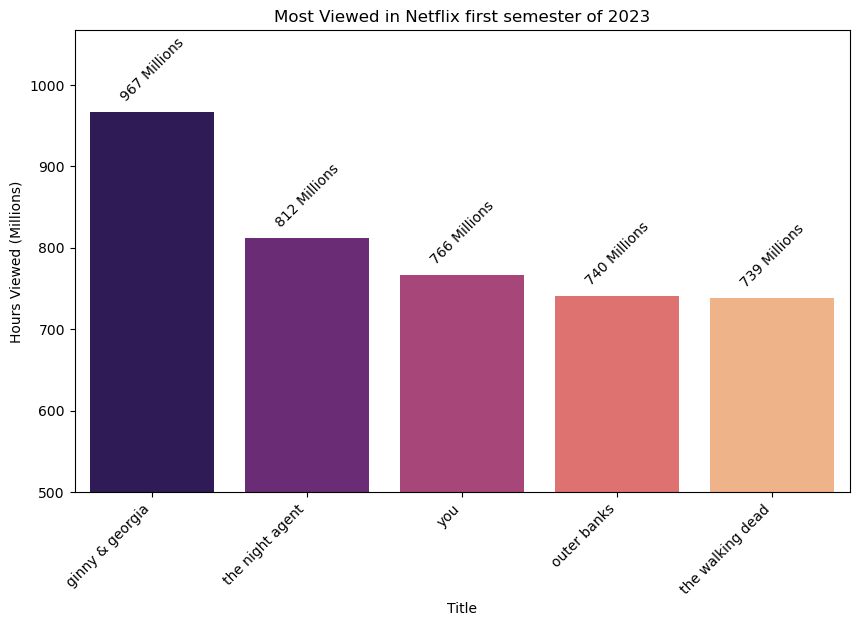

In [182]:
#now we want to represent the 5 most viewed titles on the first semester of 2023

#create a dataframe with the 5 most viewed titles
top5_resultdf = result_df.nlargest(5,'Hours Viewed')
# Convert 'Hours Viewed' to millions for better readability
top5_resultdf['Hours Viewed (Millions)'] = top5_resultdf['Hours Viewed'] / 1_000_000

# Create a vertical bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Title', y='Hours Viewed (Millions)', data=top5_resultdf, palette='magma')

# Set y-axis limits to start at 500 million
plt.ylim(500, top5_resultdf['Hours Viewed (Millions)'].max() + 100)  

for index, value in enumerate(top5_resultdf['Hours Viewed (Millions)']):
    plt.text(index, value + 10, f'{value:.0f} Millions', ha='center', va='bottom', rotation=45, color='black')
# Set plot labels and title
plt.xlabel('Title')
plt.ylabel('Hours Viewed (Millions)')
plt.title('Most Viewed in Netflix first semester of 2023')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [183]:
#we can constat that the top 5 of the most viewed in Netflix in the first semester of 2023 are all TV shows

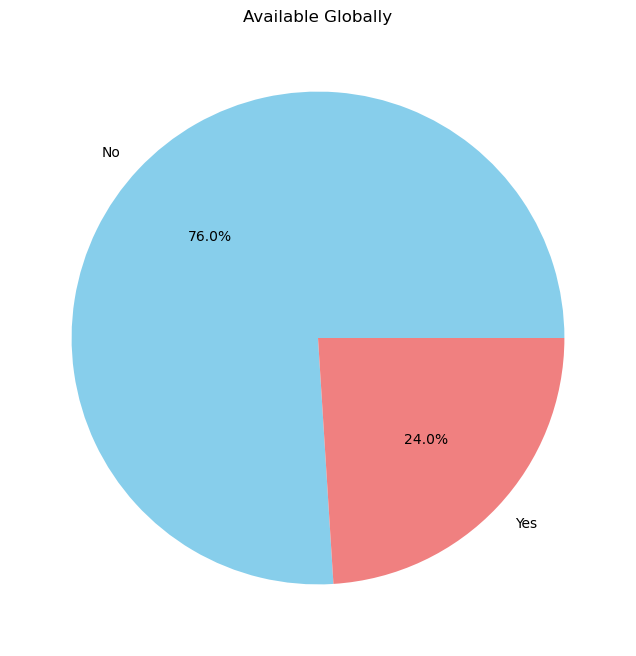

In [184]:
#now we want to make a representation of to see the part of titles available globally or not
distribution = result_df['Available Globally'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(distribution, labels=distribution.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Available Globally')

# Show the plot
plt.show()

In [185]:
# we constat that most titles are not available globally, Netflix adapts in function of the country


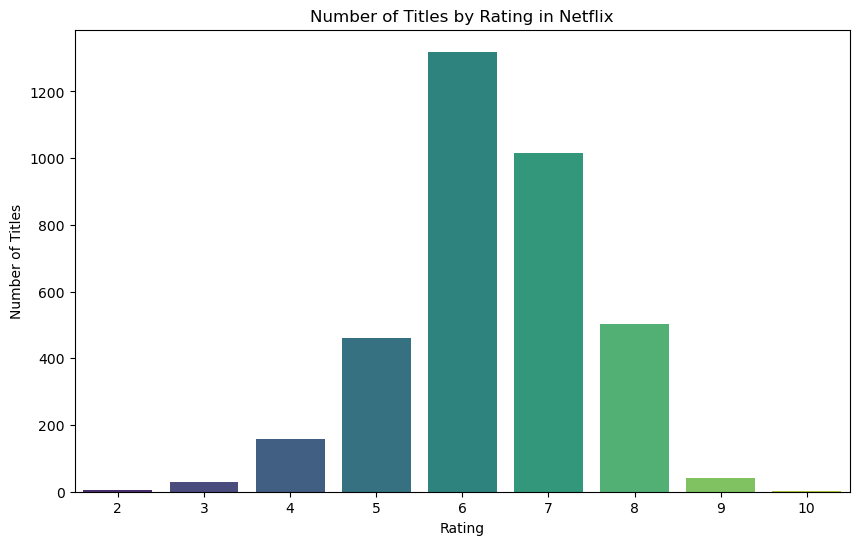

In [201]:
#we represent the number of titles by rating
df_rating_hours['rounded_rating'] = df_rating_hours['rating'].round().astype(int)
df_rating_counts = df_rating_hours.groupby('rounded_rating')['Title'].size().reset_index(name='title_count')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='rounded_rating', y='title_count', data=df_rating_counts, palette='viridis')

# Set plot labels and title
plt.xlabel('Rating')
plt.ylabel('Number of Titles')
plt.title('Number of Titles by Rating in Netflix')

# Show the plot
plt.show()

In [202]:
#we see that in netflix there is not titles with 0 rating and few with 2 rating and the graph kind of follow a normal
#law with a slight deviation on the right

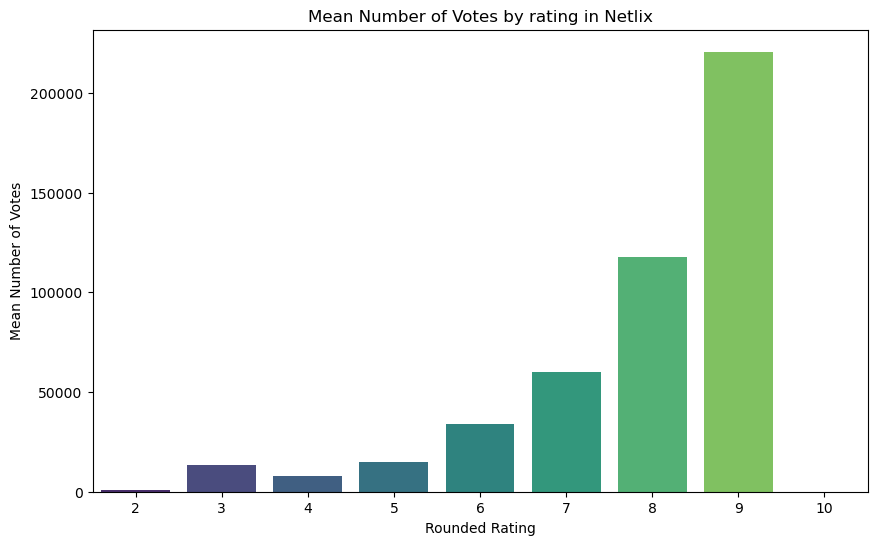

In [206]:
#now we to see the mean number of votes in relationship with rating


# Calculate the mean number of votes for each rounded integer rating
mean_votes_by_rating_rounded = df_rating_hours.groupby('rounded_rating')['number of votes'].mean().reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='rounded_rating', y='number of votes', data=mean_votes_by_rating_rounded, palette='viridis')

# Set plot labels and title
plt.xlabel('Rounded Rating')
plt.ylabel('Mean Number of Votes')
plt.title('Mean Number of Votes by rating in Netlix')

plt.show()
# We see 

In [207]:
# we clearly see that the more the rating is elevated, the more votes the titles have


In [210]:
# now we are going to analyse the distribution of hours viewed between movies and tv shows
query_2 = """
SELECT Netflix_values.Title,
Netflix_values."Hours Viewed",
Netflix_values."Available Globally",
Netflix_values.Year,
Title_IMDB.Type


FROM Netflix_values
INNER JOIN Title_IMDB
ON Netflix_values.Title = Title_IMDB.Title 
AND Netflix_values.Year = Title_IMDB."Release year"
"""

df_type_by_hour = pd.read_sql_query(query_2,connection)

Text(0.5, 1.0, 'type for hours viewed')

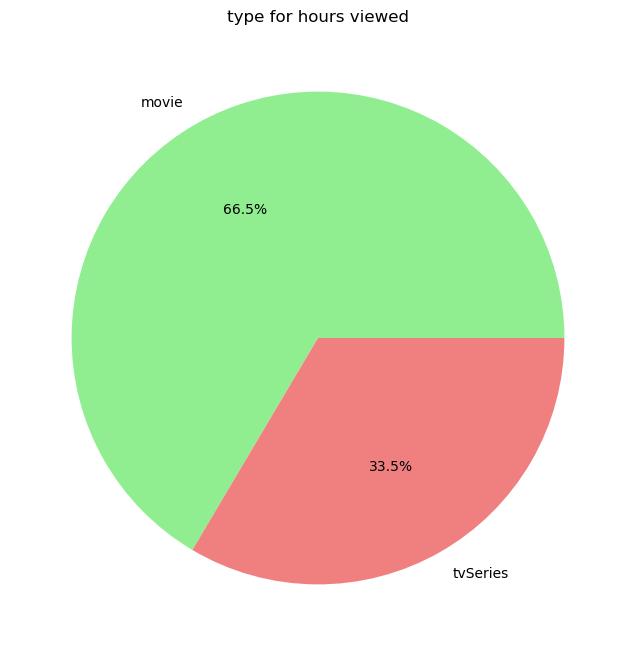

In [211]:
distribution = df_type_by_hour['Type'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(distribution, labels=distribution.index, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('type for hours viewed')

#we can see that despite having only tv shows in the 5 most viewed , in general there are more hours
#spend viewing movies on netflix

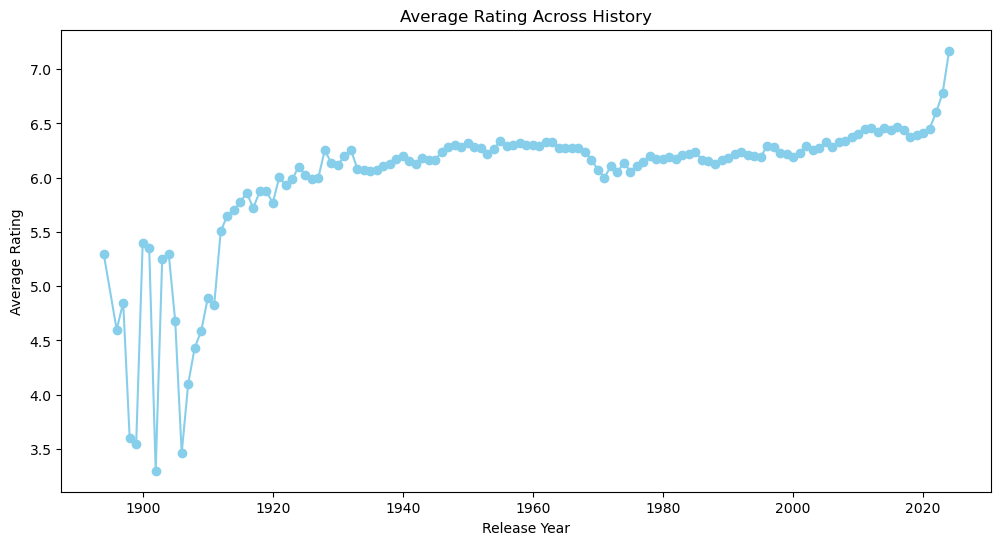

In [212]:
# we make a visual to see the evolution of rating across history
query_3= """
SELECT Title_IMDB."Release Year",
avg(Rating_IMDB.rating)
FROM Title_IMDB
JOIN Rating_IMDB
ON Title_IMDB.Id = Rating_IMDB.Id
GROUP BY Title_IMDB."Release Year" ;
"""
df_rating_history = pd.read_sql_query(query_3,connection)

#we filter where release date different from \N
df_rating_history=df_rating_history[df_rating_history['Release Year'] != r'\N']
df_rating_history['Release Year'] = pd.to_datetime(df_rating_history['Release Year'])

plt.figure(figsize=(12, 6))

# Plotting the line plot
plt.plot(df_rating_history['Release Year'], df_rating_history['avg(Rating_IMDB.rating)'], marker='o', color='skyblue')

# Adding labels and title
plt.xlabel('Release Year')
plt.ylabel('Average Rating')
plt.title('Average Rating Across History')

# Display the plot
plt.show()


In [213]:
#We can observe that movies and tv shows at the beginning of 20th century don't have good ratings, then from 1920 
#to 2020 it more or less stable
#there is a steep increase of average ratings from 2020


In [ ]:
#now we want to see the proportion of each genre in netflix

query_4 = """
SELECT Netflix_values.Title,
Netflix_values."Hours Viewed",
Rating_IMDB.rating,
Rating_IMDB."number of votes",
Netflix_values."Available Globally",
Netflix_values.Year,
Title_IMDB.genres


FROM Netflix_values
INNER JOIN Title_IMDB
ON Netflix_values.Title = Title_IMDB.Title 
AND Netflix_values.Year = Title_IMDB."Release year"
JOIN Rating_IMDB
ON Title_IMDB.Id = Rating_IMDB.Id
"""

df_genre = pd.read_sql_query(query_4,connection)

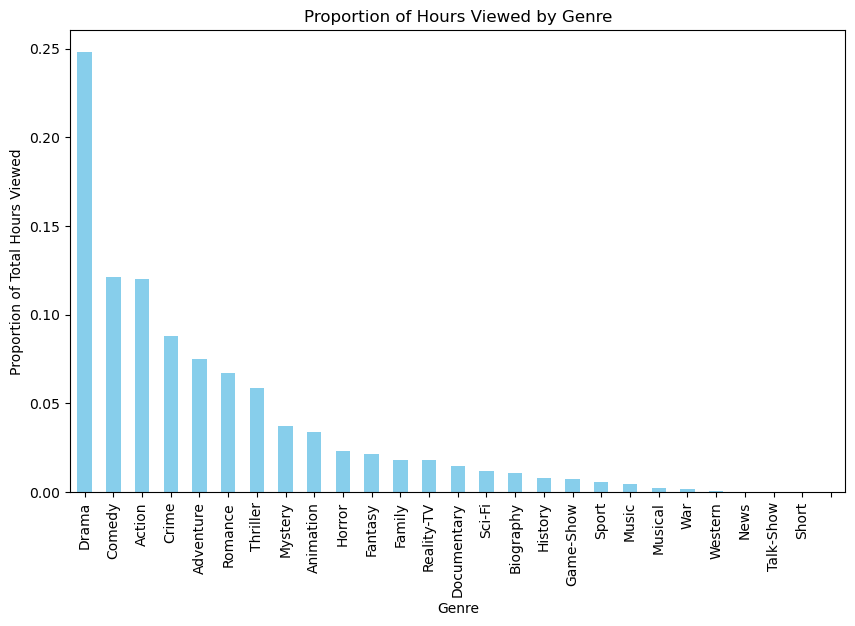

In [220]:
# now we want to see the proportion of hours viewed by genre

# Preprocess data to handle multiple genres
df_genre['genres'] = df_genre['genres'].str.split(',')

# Create a DataFrame with one row per genre and Title-Hours Viewed information
df_processed = df_genre.explode('genres')

# Calculate total hours viewed for each genre
total_hours_by_genre = df_processed.groupby('genres')['Hours Viewed'].sum()

# Calculate the proportion of hours viewed for each genre
proportion_hours_by_genre = total_hours_by_genre / total_hours_by_genre.sum()

# Create a bar plot
plt.figure(figsize=(10, 6))
proportion_hours_by_genre.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Proportion of Hours Viewed by Genre')
plt.xlabel('Genre')
plt.ylabel('Proportion of Total Hours Viewed')
plt.show()

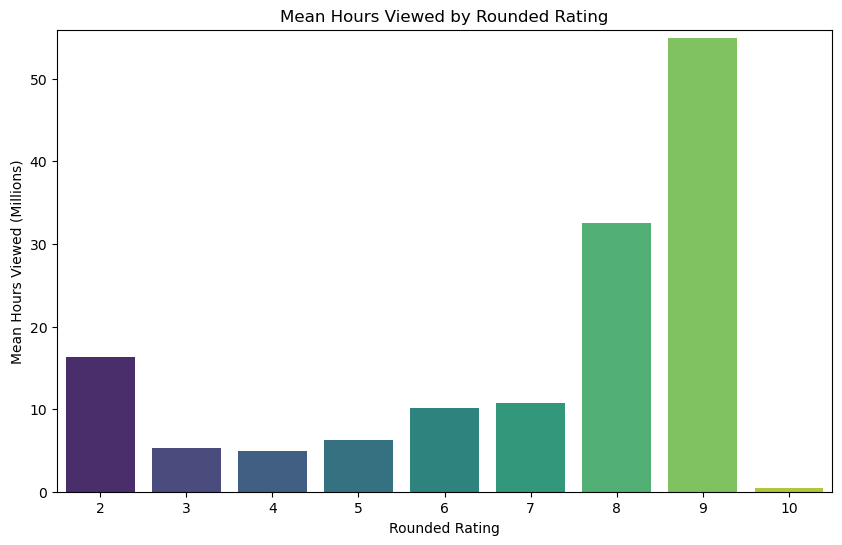

In [226]:
#So finally we want to see if there is a relationship between the hours viewed and the rating
#we make a graph representing the average hours viewed by each rating

mean_hours_by_rating_rounded = df_rating_hours.groupby('rounded_rating')['Hours Viewed'].mean().reset_index()
# Convert 'Hours Viewed' to millions for better readability
mean_hours_by_rating_rounded['Hours Viewed (Millions)'] = mean_hours_by_rating_rounded['Hours Viewed'] / 1_000_000

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='rounded_rating', y='Hours Viewed (Millions)', data=mean_hours_by_rating_rounded, palette='viridis')

# Set y-axis limits or adjust the upper limit as needed
plt.ylim(0, mean_hours_by_rating_rounded['Hours Viewed (Millions)'].max() + 1)

# Set plot labels and title
plt.xlabel('Rounded Rating')
plt.ylabel('Mean Hours Viewed (Millions)')
plt.title('Mean Hours Viewed by Rounded Rating')

# Show the plot
plt.show()

In [227]:
#we see that except 2 and 10 (rating)there is a tendancy that show the more the rating the more there are hours viewed